# OTP vs. Load Factor Analysis: Southwest's Top 5 Routes

This notebook analyzes the relationship between **Southwest Airlines' On-Time Performance (OTP)** and **Load Factor** on the top 5 domestic routes.

**Research Question:**  
How does Southwest's OTP relate to the Load Factor of its flights on the top 5 domestic routes?

---

## Import Libraries and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
sys.path.append('..')

from src import MetricsCalculator

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# %matplotlib inline

---


### Cell 1. Load Top 5 Routes Data

In [2]:
# Load processed data
lf_top5 = pd.read_csv('../data/processed/lf_top5_routes.csv')
otp_top5 = pd.read_csv('../data/processed/otp_top5_routes.csv')
top_routes = pd.read_csv('../data/processed/top5_routes.csv')['ROUTE'].tolist()

# Convert dates
lf_top5['DATE'] = pd.to_datetime(lf_top5['DATE'])
otp_top5['DATE'] = pd.to_datetime(otp_top5['DATE'])

print(f"Top 5 Routes: {', '.join(top_routes)}")
print(f"\nLoad Factor records: {len(lf_top5):,}")
print(f"OTP records: {len(otp_top5):,}")

Top 5 Routes: DEN-PHX, SAN-SMF, DAL-HOU, BWI-MCO, SAN-SJC

Load Factor records: 1,860
OTP records: 204,767


---


### Cell 2. Merge Load Factor and OTP Data

In [3]:
# Use MetricsCalculator to merge data
calc = MetricsCalculator()
merged_data = calc.merge_lf_otp_by_route_month(lf_top5, otp_top5)

print(f"Merged dataset shape: {merged_data.shape}")
print(f"Date range: {merged_data['DATE'].min()} to {merged_data['DATE'].max()}")
print(f"\nRoutes in merged data: {merged_data['ROUTE'].nunique()}")
merged_data.head(10)


# Check data availability by route
route_counts = merged_data.groupby('ROUTE').size().sort_values(ascending=False)
print("Number of months with data by route:")
print(route_counts)

Merged dataset shape: (330, 21)
Date range: 2020-01-01 00:00:00 to 2025-06-01 00:00:00

Routes in merged data: 5
Number of months with data by route:
ROUTE
BWI-MCO    66
DAL-HOU    66
DEN-PHX    66
SAN-SJC    66
SAN-SMF    66
dtype: int64


---


### Cell 3. Calculate Summary Statistics by Route

In [4]:
# Calculate summary statistics for each route
summary_stats = []

for route in top_routes:
    stats = calc.route_summary_stats(merged_data, route)
    if stats:
        summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.sort_values('total_flights', ascending=False)

print("\nSummary Statistics by Route:")
print("="*100)
summary_df


# Display correlations more clearly
print("\nLoad Factor vs OTP Correlations:")
print("="*80)
correlation_summary = summary_df[[
    'route', 'corr_lf_dep_ontime', 'corr_lf_dep_pvalue', 
    'corr_lf_arr_ontime', 'corr_lf_arr_pvalue'
]].copy()

# Add significance markers
def add_significance(row):
    dep_sig = '***' if row['corr_lf_dep_pvalue'] < 0.001 else \
              '**' if row['corr_lf_dep_pvalue'] < 0.01 else \
              '*' if row['corr_lf_dep_pvalue'] < 0.05 else 'ns'
    arr_sig = '***' if row['corr_lf_arr_pvalue'] < 0.001 else \
              '**' if row['corr_lf_arr_pvalue'] < 0.01 else \
              '*' if row['corr_lf_arr_pvalue'] < 0.05 else 'ns'
    return pd.Series([dep_sig, arr_sig])

correlation_summary[['dep_sig', 'arr_sig']] = correlation_summary.apply(add_significance, axis=1)
print(correlation_summary)
print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")



Summary Statistics by Route:

Load Factor vs OTP Correlations:
     route  corr_lf_dep_ontime  corr_lf_dep_pvalue  corr_lf_arr_ontime  \
2  DAL-HOU               -0.79                0.00               -0.72   
0  DEN-PHX               -0.70                0.00               -0.66   
1  SAN-SMF               -0.75                0.00               -0.70   
4  SAN-SJC               -0.77                0.00               -0.75   
3  BWI-MCO               -0.78                0.00               -0.74   

   corr_lf_arr_pvalue dep_sig arr_sig  
2                0.00     ***     ***  
0                0.00     ***     ***  
1                0.00     ***     ***  
4                0.00     ***     ***  
3                0.00     ***     ***  

Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


---


### Cell 4. Visualize Overall Relationship

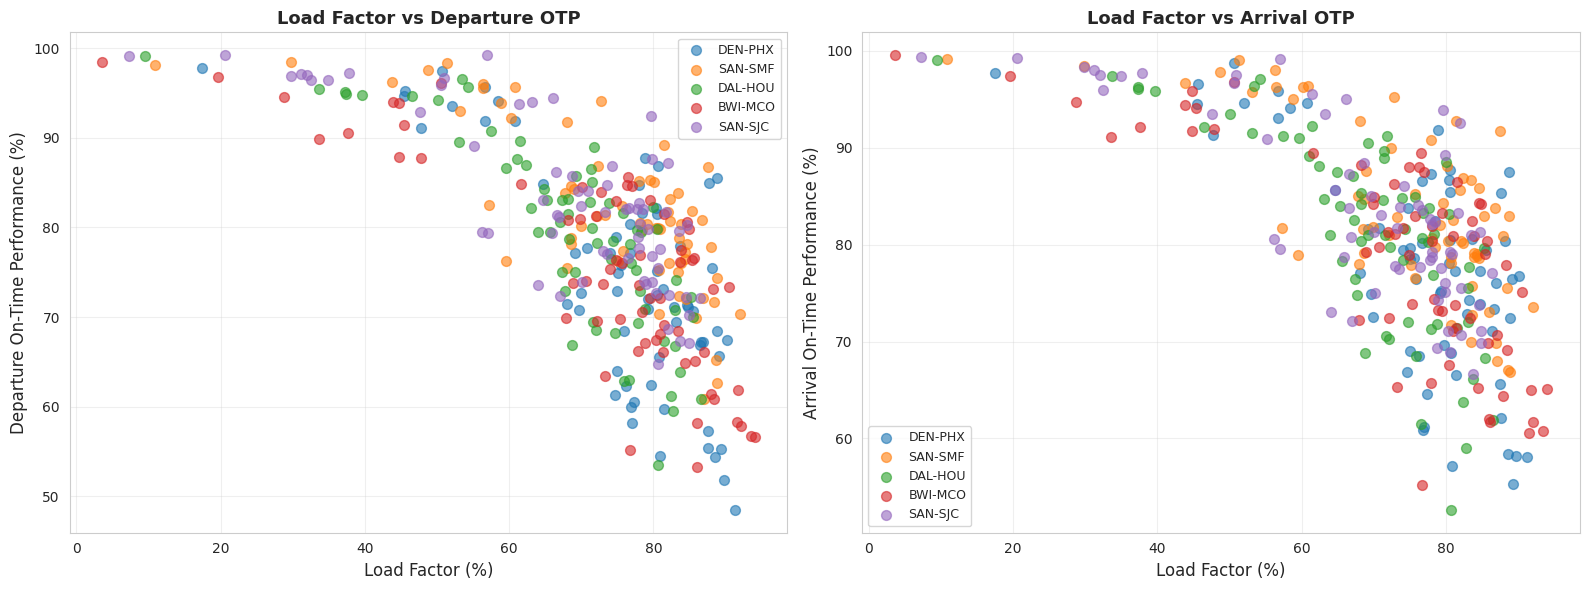

In [5]:
# Scatter plot: Load Factor vs Departure On-Time Performance (All Routes)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Departure OTP
for route in top_routes:
    route_data = merged_data[merged_data['ROUTE'] == route]
    axes[0].scatter(route_data['LOAD_FACTOR'], route_data['DEP_ONTIME_PCT'], 
                    label=route, alpha=0.6, s=50)

axes[0].set_xlabel('Load Factor (%)', fontsize=12)
axes[0].set_ylabel('Departure On-Time Performance (%)', fontsize=12)
axes[0].set_title('Load Factor vs Departure OTP', fontsize=13, fontweight='bold')
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Arrival OTP
for route in top_routes:
    route_data = merged_data[merged_data['ROUTE'] == route]
    axes[1].scatter(route_data['LOAD_FACTOR'], route_data['ARR_ONTIME_PCT'], 
                    label=route, alpha=0.6, s=50)

axes[1].set_xlabel('Load Factor (%)', fontsize=12)
axes[1].set_ylabel('Arrival On-Time Performance (%)', fontsize=12)
axes[1].set_title('Load Factor vs Arrival OTP', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---


### Cell 5. Individual Route Analysis

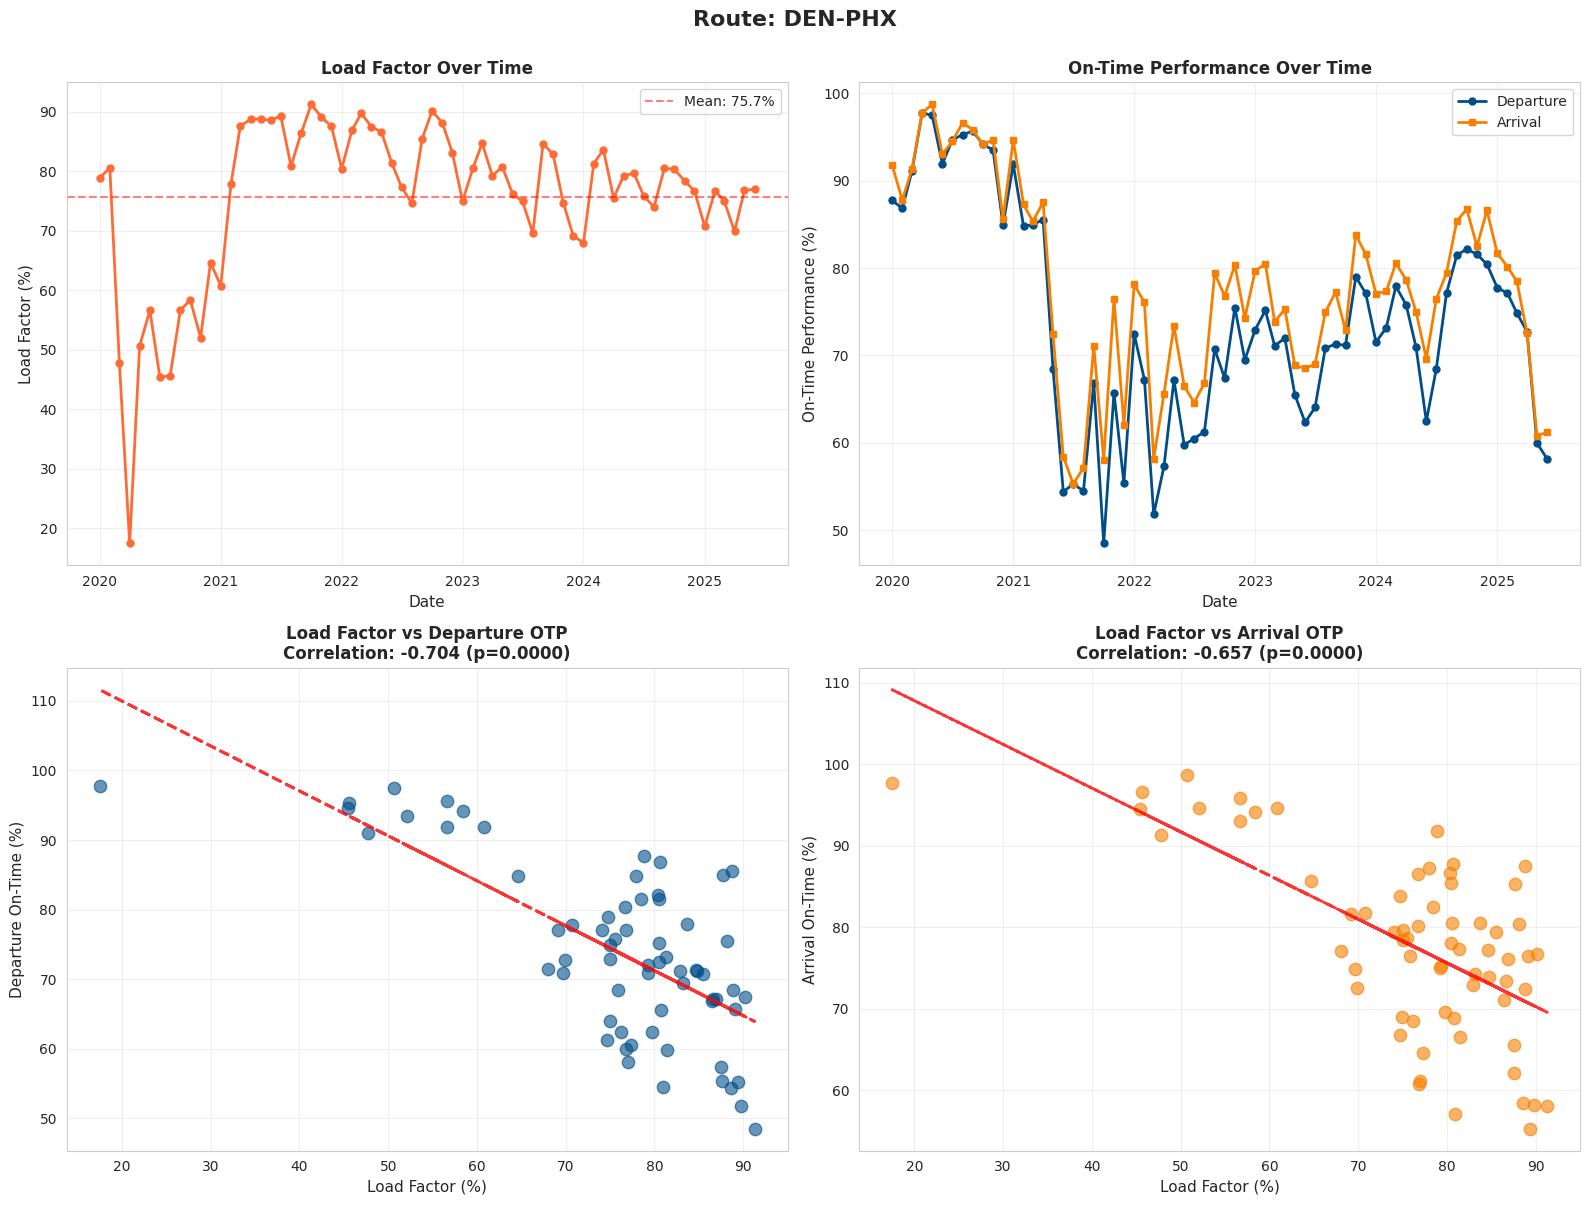


Route DEN-PHX - Key Metrics:
Average Load Factor: 75.70%
Average Departure OTP: 73.99%
Average Arrival OTP: 77.94%
Total Flights Analyzed: 42,484




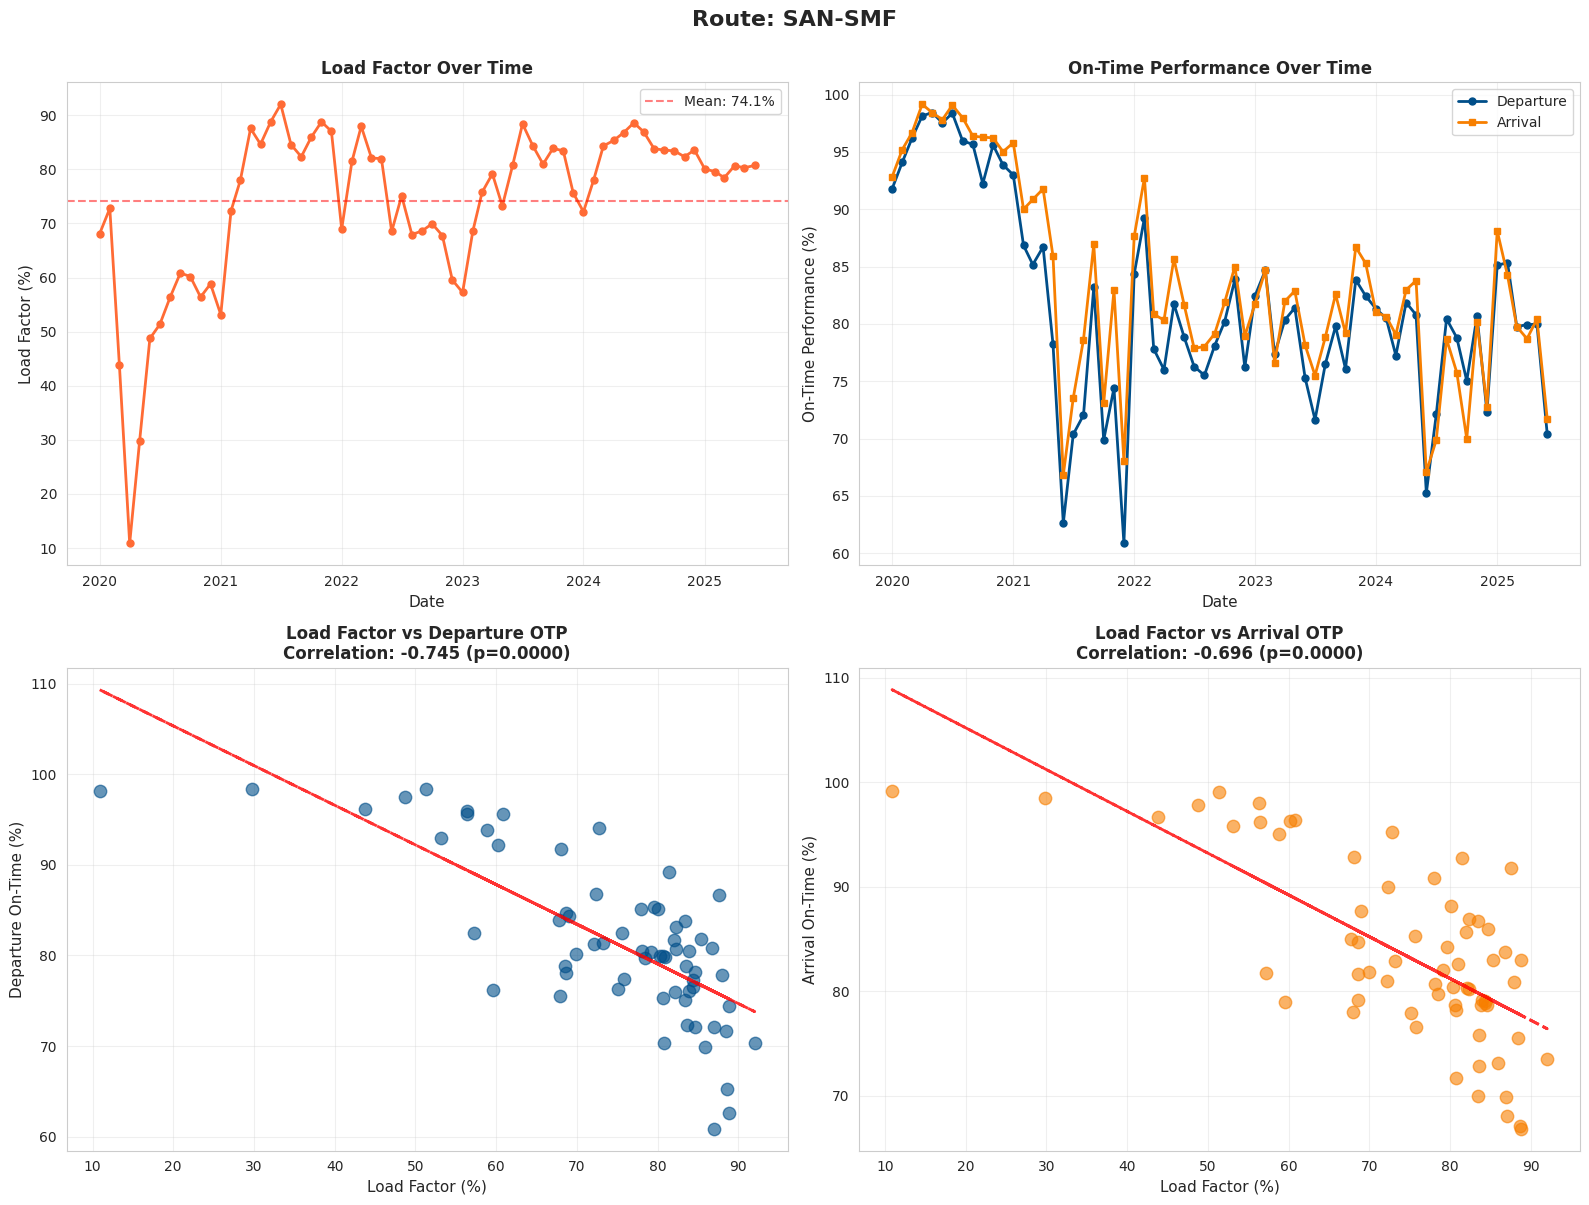


Route SAN-SMF - Key Metrics:
Average Load Factor: 74.15%
Average Departure OTP: 81.64%
Average Arrival OTP: 83.54%
Total Flights Analyzed: 41,362




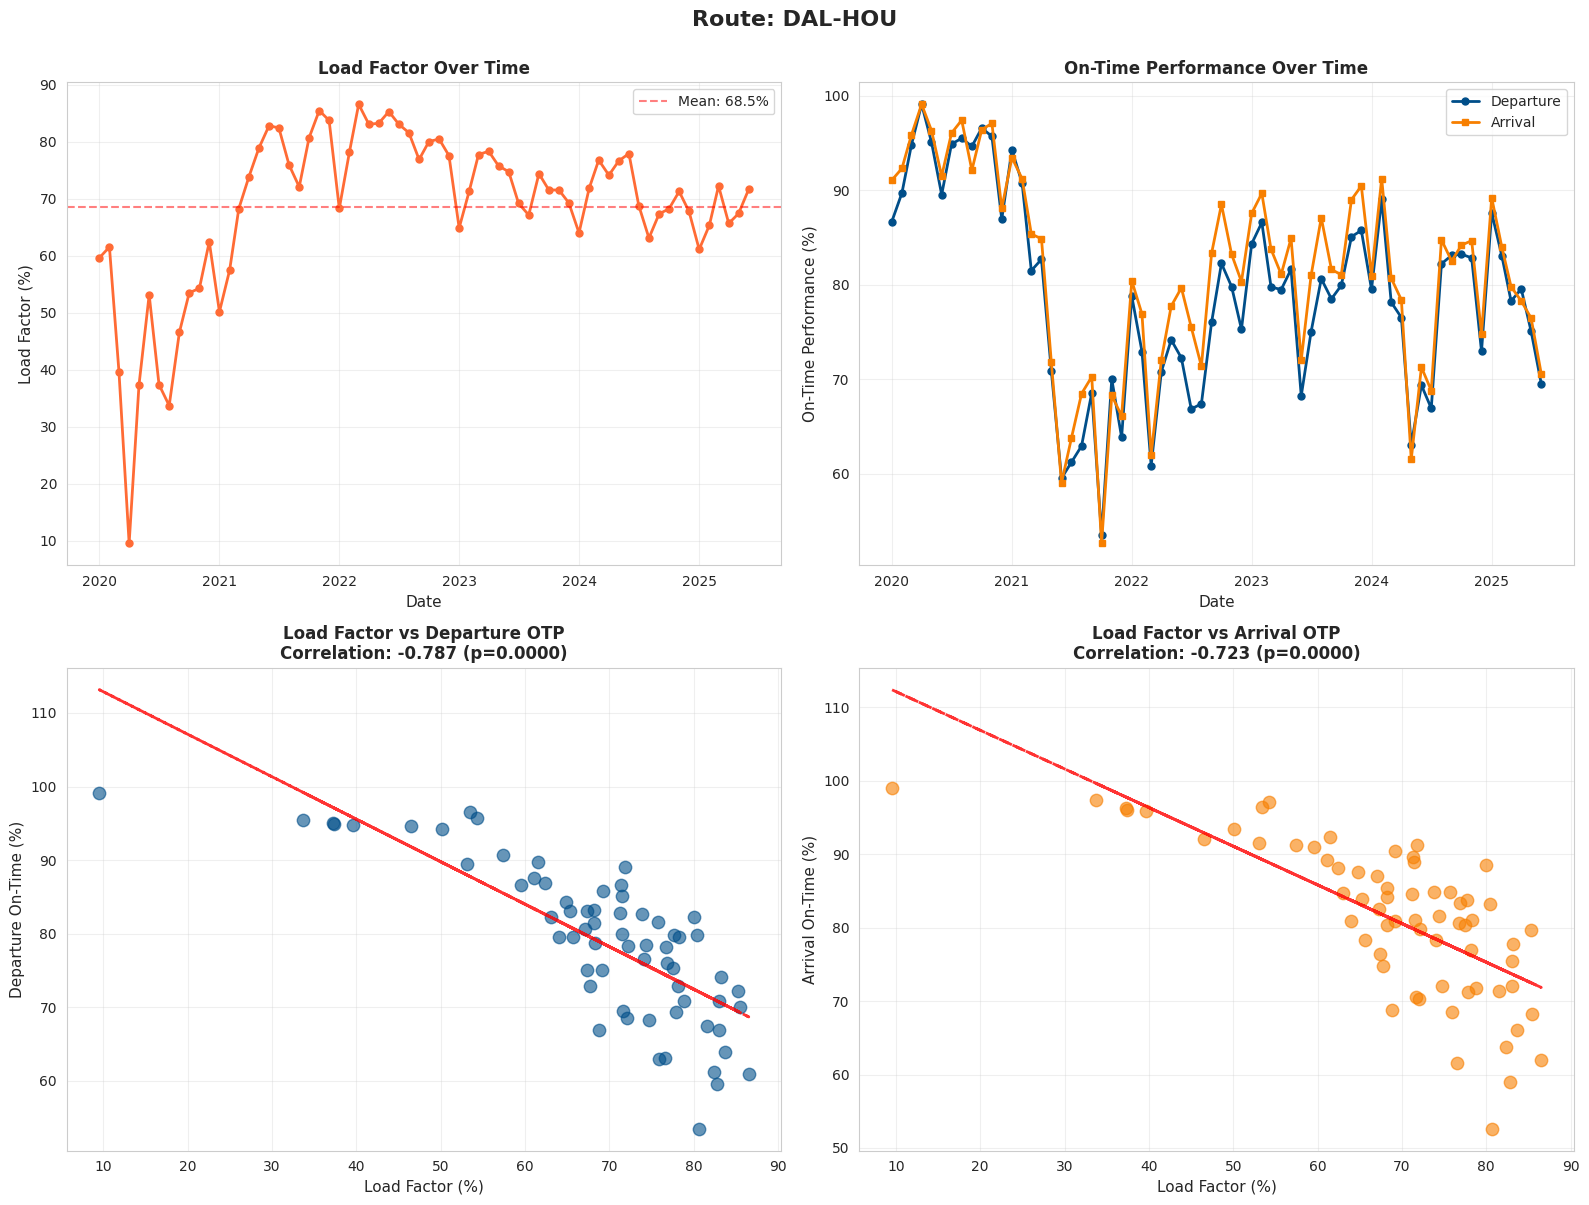


Route DAL-HOU - Key Metrics:
Average Load Factor: 68.48%
Average Departure OTP: 79.10%
Average Arrival OTP: 81.36%
Total Flights Analyzed: 43,057




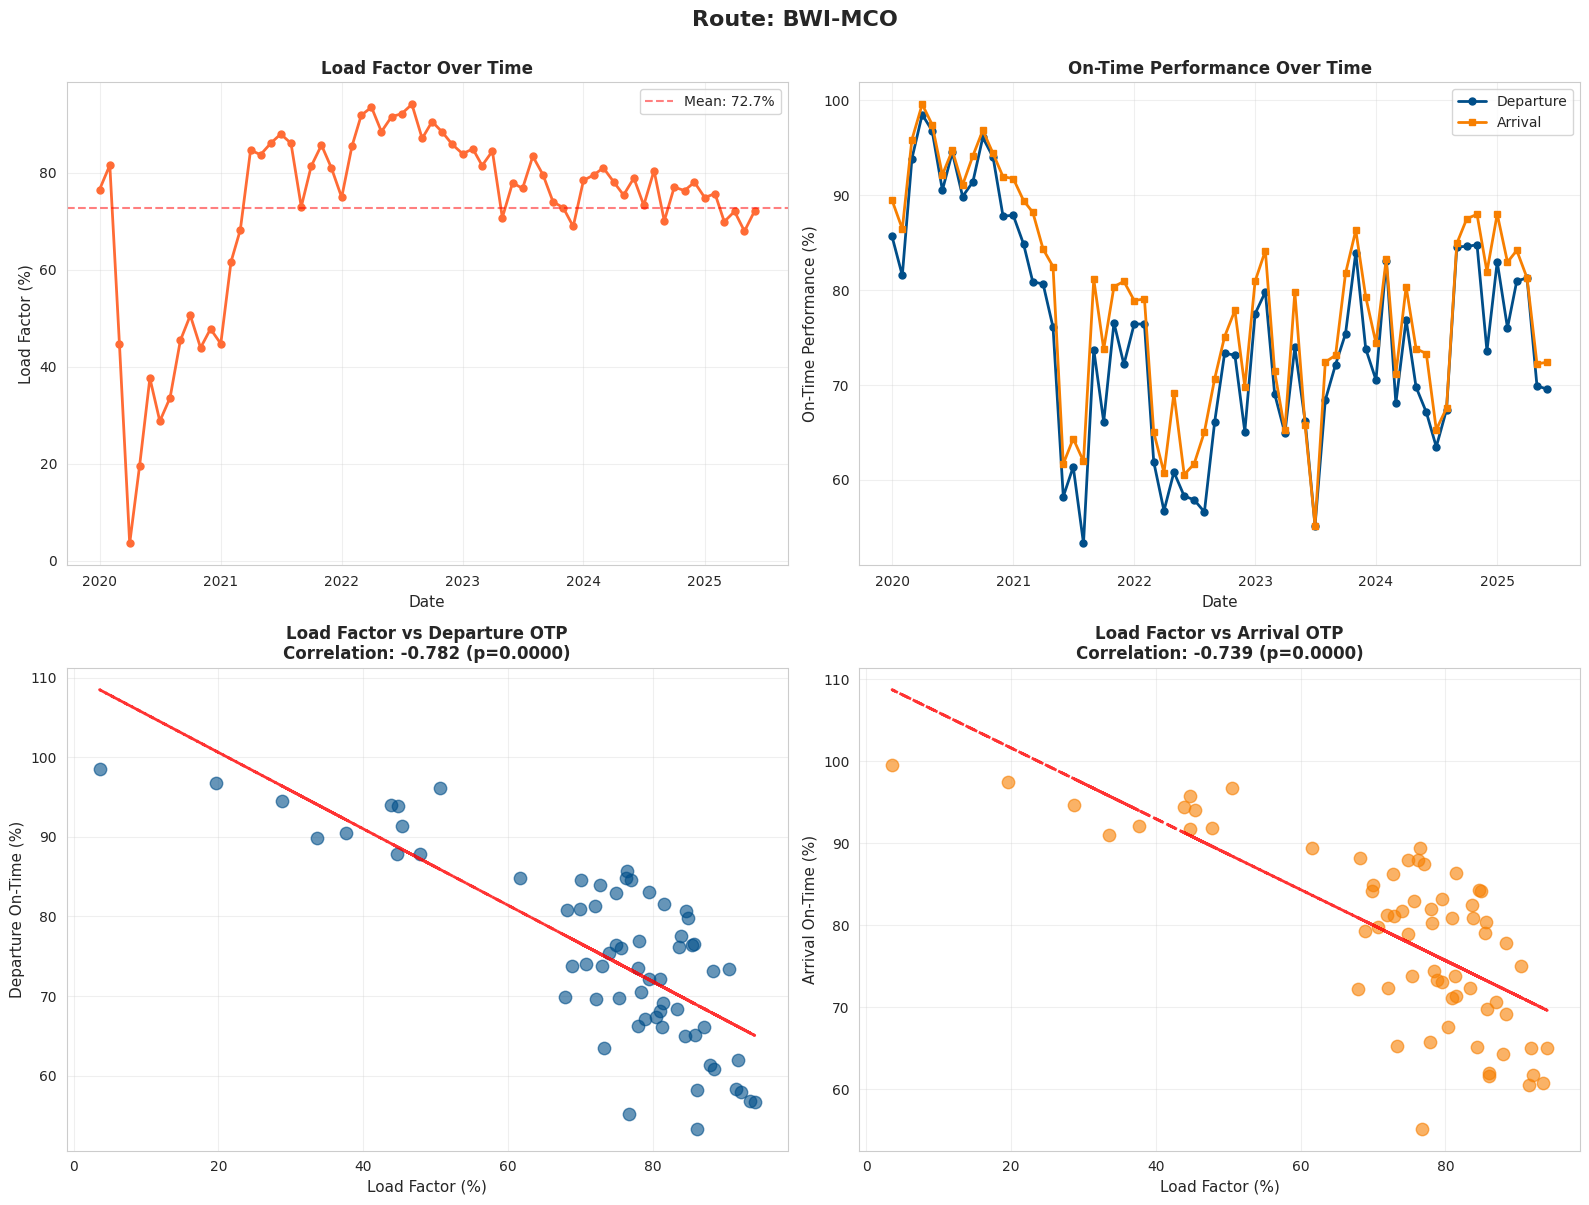


Route BWI-MCO - Key Metrics:
Average Load Factor: 72.70%
Average Departure OTP: 75.31%
Average Arrival OTP: 78.88%
Total Flights Analyzed: 37,188




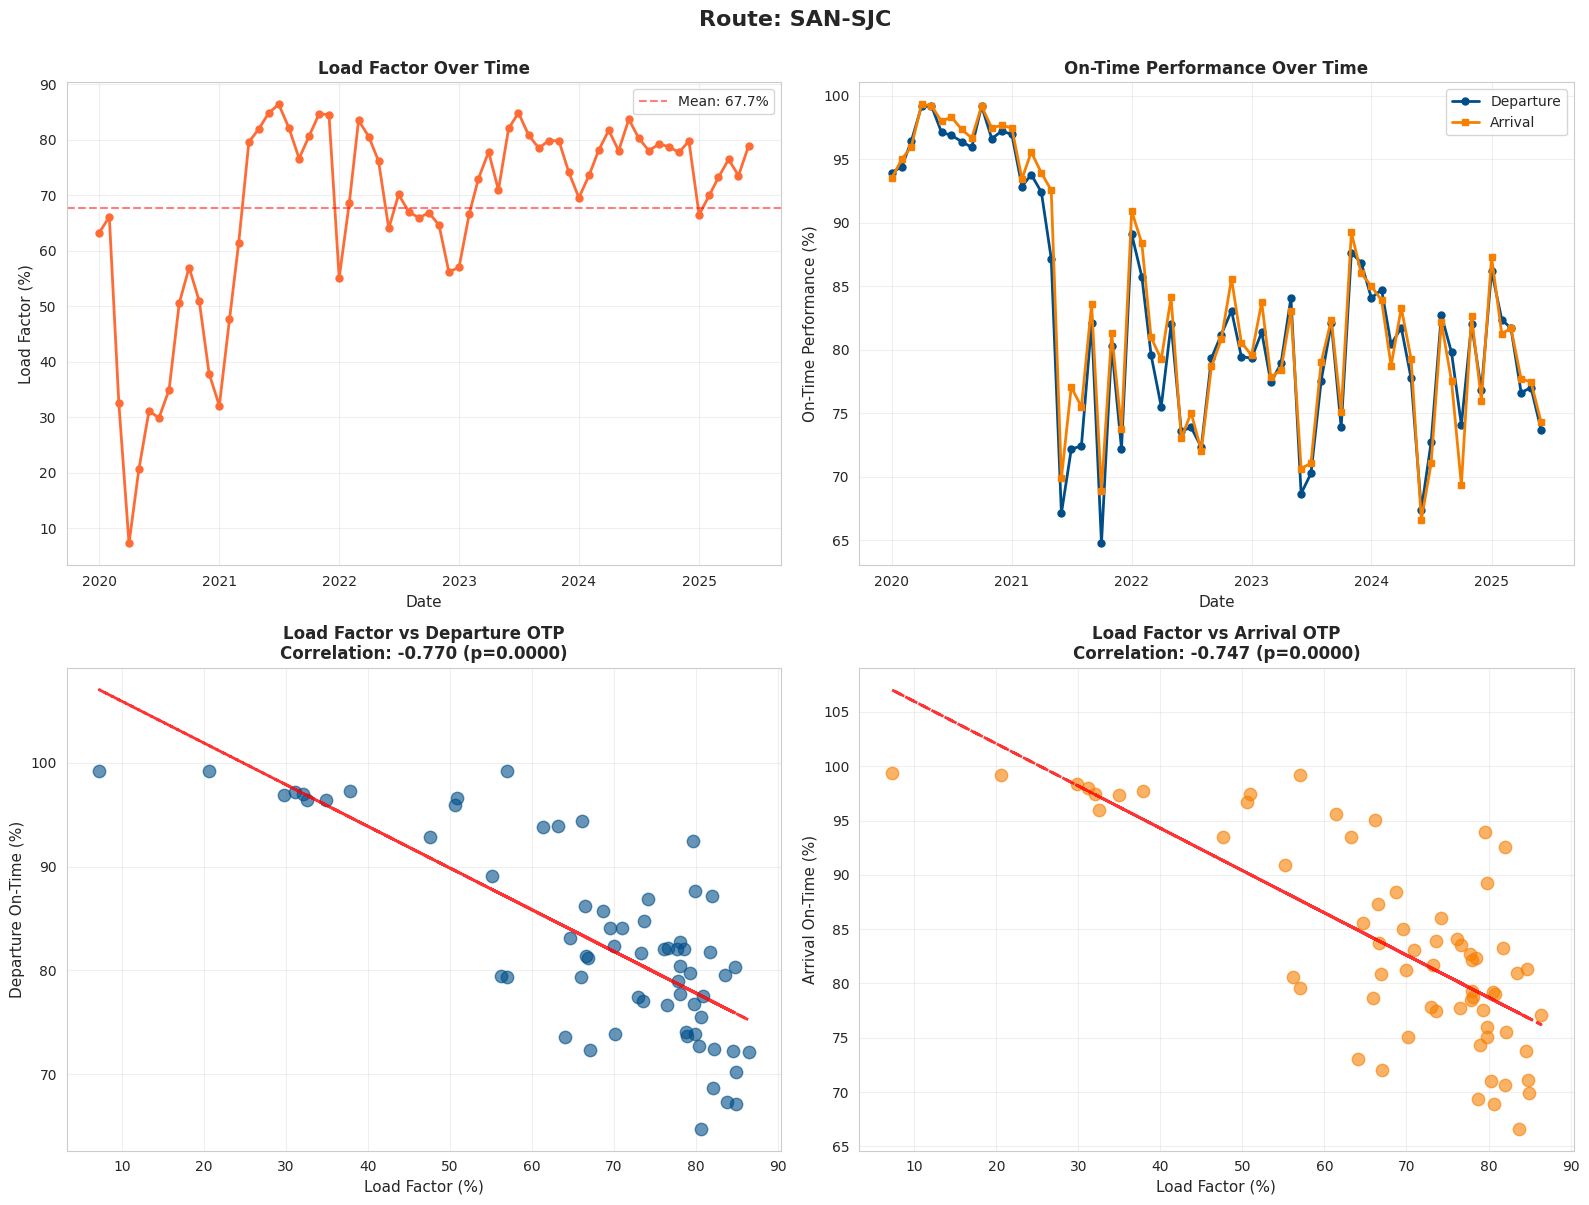


Route SAN-SJC - Key Metrics:
Average Load Factor: 67.67%
Average Departure OTP: 82.76%
Average Arrival OTP: 83.51%
Total Flights Analyzed: 40,676




In [6]:
# Create detailed plots for each route
for route in top_routes:
    route_data = merged_data[merged_data['ROUTE'] == route]
    
    if len(route_data) == 0:
        continue
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Route: {route}', fontsize=16, fontweight='bold', y=1.00)
    
    # Plot 1: Time series - Load Factor
    ax1 = axes[0, 0]
    ax1.plot(route_data['DATE'], route_data['LOAD_FACTOR'], 
             marker='o', linewidth=2, markersize=5, color='#FF6B35')
    ax1.set_xlabel('Date', fontsize=11)
    ax1.set_ylabel('Load Factor (%)', fontsize=11)
    ax1.set_title('Load Factor Over Time', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=route_data['LOAD_FACTOR'].mean(), color='red', 
                linestyle='--', alpha=0.5, label=f"Mean: {route_data['LOAD_FACTOR'].mean():.1f}%")
    ax1.legend()
    
    # Plot 2: Time series - OTP
    ax2 = axes[0, 1]
    ax2.plot(route_data['DATE'], route_data['DEP_ONTIME_PCT'], 
             marker='o', linewidth=2, markersize=5, label='Departure', color='#004E89')
    ax2.plot(route_data['DATE'], route_data['ARR_ONTIME_PCT'], 
             marker='s', linewidth=2, markersize=5, label='Arrival', color='#F77F00')
    ax2.set_xlabel('Date', fontsize=11)
    ax2.set_ylabel('On-Time Performance (%)', fontsize=11)
    ax2.set_title('On-Time Performance Over Time', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Scatter - Load Factor vs Departure OTP
    ax3 = axes[1, 0]
    ax3.scatter(route_data['LOAD_FACTOR'], route_data['DEP_ONTIME_PCT'], 
                alpha=0.6, s=80, color='#004E89')
    
    # Add regression line
    z = np.polyfit(route_data['LOAD_FACTOR'], route_data['DEP_ONTIME_PCT'], 1)
    p = np.poly1d(z)
    ax3.plot(route_data['LOAD_FACTOR'], p(route_data['LOAD_FACTOR']), 
             "r--", alpha=0.8, linewidth=2)
    
    corr = calc.calculate_correlation(route_data, 'LOAD_FACTOR', 'DEP_ONTIME_PCT')
    ax3.set_xlabel('Load Factor (%)', fontsize=11)
    ax3.set_ylabel('Departure On-Time (%)', fontsize=11)
    ax3.set_title(f"Load Factor vs Departure OTP\n" +
                  f"Correlation: {corr['correlation']:.3f} (p={corr['p_value']:.4f})", 
                  fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Scatter - Load Factor vs Arrival OTP
    ax4 = axes[1, 1]
    ax4.scatter(route_data['LOAD_FACTOR'], route_data['ARR_ONTIME_PCT'], 
                alpha=0.6, s=80, color='#F77F00')
    
    # Add regression line
    z = np.polyfit(route_data['LOAD_FACTOR'], route_data['ARR_ONTIME_PCT'], 1)
    p = np.poly1d(z)
    ax4.plot(route_data['LOAD_FACTOR'], p(route_data['LOAD_FACTOR']), 
             "r--", alpha=0.8, linewidth=2)
    
    corr = calc.calculate_correlation(route_data, 'LOAD_FACTOR', 'ARR_ONTIME_PCT')
    ax4.set_xlabel('Load Factor (%)', fontsize=11)
    ax4.set_ylabel('Arrival On-Time (%)', fontsize=11)
    ax4.set_title(f"Load Factor vs Arrival OTP\n" +
                  f"Correlation: {corr['correlation']:.3f} (p={corr['p_value']:.4f})", 
                  fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"Route {route} - Key Metrics:")
    print(f"{'='*80}")
    print(f"Average Load Factor: {route_data['LOAD_FACTOR'].mean():.2f}%")
    print(f"Average Departure OTP: {route_data['DEP_ONTIME_PCT'].mean():.2f}%")
    print(f"Average Arrival OTP: {route_data['ARR_ONTIME_PCT'].mean():.2f}%")
    print(f"Total Flights Analyzed: {route_data['TOTAL_FLIGHTS'].sum():,.0f}")
    print(f"\n")

---


### Cell 6. Correlation Heatmap

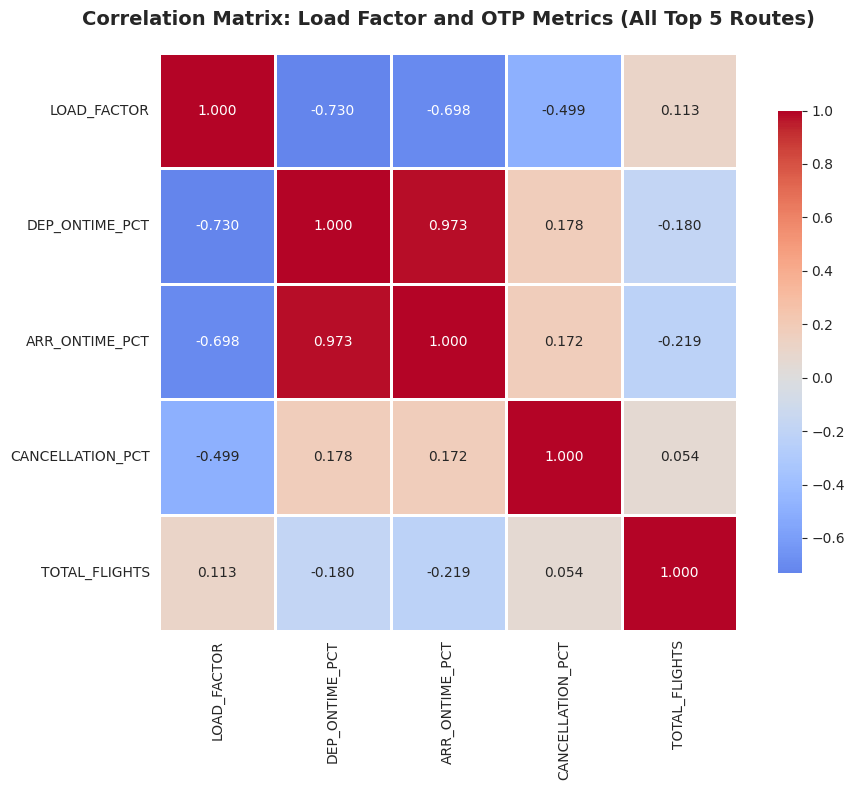

In [7]:
# Create correlation matrix for key variables
corr_vars = ['LOAD_FACTOR', 'DEP_ONTIME_PCT', 'ARR_ONTIME_PCT', 
             'CANCELLATION_PCT', 'TOTAL_FLIGHTS']
corr_matrix = merged_data[corr_vars].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Load Factor and OTP Metrics (All Top 5 Routes)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

---


### Cell 7. Load Factor Bins Analysis

OTP by Load Factor Bin:
       DEP_ONTIME_PCT      ARR_ONTIME_PCT      CANCELLATION_PCT TOTAL_FLIGHTS
                 mean  std           mean  std             mean           sum
LF_BIN                                                                       
<70%            88.08 8.42          89.56 7.93             5.39         68062
70-75%          78.27 7.34          80.70 6.77             1.95         26109
75-80%          76.01 7.96          78.44 8.00             1.72         42071
80-85%          73.86 7.52          76.63 7.96             1.85         42961
85%+            66.97 9.38          71.55 8.87             2.65         25564


/tmp/ipykernel_12941/1975365841.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_analysis = merged_data.groupby('LF_BIN').agg({
/tmp/ipykernel_12941/1975365841.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = merged_data.groupby('LF_BIN').agg({


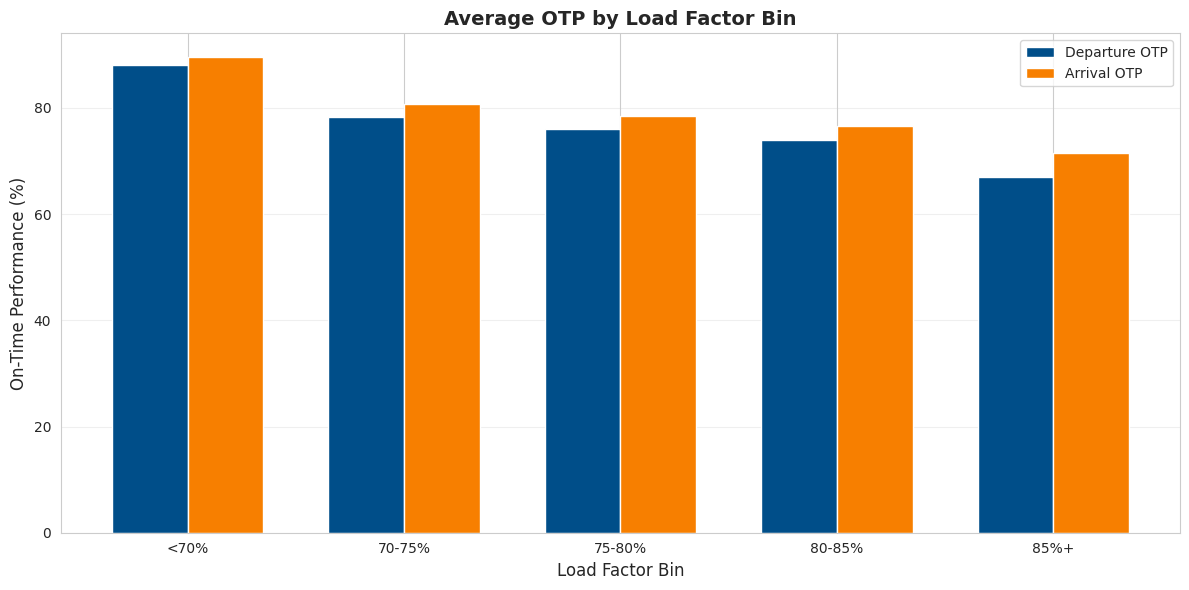

In [8]:
# Create load factor bins
merged_data['LF_BIN'] = pd.cut(merged_data['LOAD_FACTOR'], 
                                bins=[0, 70, 75, 80, 85, 100],
                                labels=['<70%', '70-75%', '75-80%', '80-85%', '85%+'])

# Calculate average OTP by load factor bin
bin_analysis = merged_data.groupby('LF_BIN').agg({
    'DEP_ONTIME_PCT': ['mean', 'std'],
    'ARR_ONTIME_PCT': ['mean', 'std'],
    'CANCELLATION_PCT': 'mean',
    'TOTAL_FLIGHTS': 'sum'
}).round(2)

print("OTP by Load Factor Bin:")
print(bin_analysis)


# Visualize OTP by load factor bins
bin_summary = merged_data.groupby('LF_BIN').agg({
    'DEP_ONTIME_PCT': 'mean',
    'ARR_ONTIME_PCT': 'mean'
}).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(bin_summary))
width = 0.35

ax.bar(x - width/2, bin_summary['DEP_ONTIME_PCT'], width, 
       label='Departure OTP', color='#004E89')
ax.bar(x + width/2, bin_summary['ARR_ONTIME_PCT'], width, 
       label='Arrival OTP', color='#F77F00')

ax.set_xlabel('Load Factor Bin', fontsize=12)
ax.set_ylabel('On-Time Performance (%)', fontsize=12)
ax.set_title('Average OTP by Load Factor Bin', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(bin_summary['LF_BIN'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---


### Cell 8. Statistical Testing

In [9]:
# Perform statistical tests for overall relationship
print("Overall Statistical Analysis (All Top 5 Routes Combined)")
print("="*80)

# Pearson correlation
pearson_dep = calc.calculate_correlation(merged_data, 'LOAD_FACTOR', 'DEP_ONTIME_PCT', method='pearson')
pearson_arr = calc.calculate_correlation(merged_data, 'LOAD_FACTOR', 'ARR_ONTIME_PCT', method='pearson')

print("\nLoad Factor vs Departure OTP:")
print(f"  Pearson r = {pearson_dep['correlation']:.4f}, p = {pearson_dep['p_value']:.6f}, n = {pearson_dep['n']}")

print("\nLoad Factor vs Arrival OTP:")
print(f"  Pearson r = {pearson_arr['correlation']:.4f}, p = {pearson_arr['p_value']:.6f}, n = {pearson_arr['n']}")

# Spearman correlation (non-parametric)
spearman_dep = calc.calculate_correlation(merged_data, 'LOAD_FACTOR', 'DEP_ONTIME_PCT', method='spearman')
spearman_arr = calc.calculate_correlation(merged_data, 'LOAD_FACTOR', 'ARR_ONTIME_PCT', method='spearman')

print("\nSpearman Rank Correlation (Load Factor vs Departure OTP):")
print(f"  Spearman ρ = {spearman_dep['correlation']:.4f}, p = {spearman_dep['p_value']:.6f}")

print("\nSpearman Rank Correlation (Load Factor vs Arrival OTP):")
print(f"  Spearman ρ = {spearman_arr['correlation']:.4f}, p = {spearman_arr['p_value']:.6f}")

Overall Statistical Analysis (All Top 5 Routes Combined)

Load Factor vs Departure OTP:
  Pearson r = -0.7304, p = 0.000000, n = 330

Load Factor vs Arrival OTP:
  Pearson r = -0.6980, p = 0.000000, n = 330

Spearman Rank Correlation (Load Factor vs Departure OTP):
  Spearman ρ = -0.6979, p = 0.000000

Spearman Rank Correlation (Load Factor vs Arrival OTP):
  Spearman ρ = -0.6660, p = 0.000000


---


### Cell 9. Save Results

In [10]:
# Save merged data
merged_data.to_csv('../data/processed/merged_lf_otp_top5.csv', index=False)

# Save summary statistics
summary_df.to_csv('../data/processed/route_summary_statistics.csv', index=False)

print("Analysis results saved to data/processed/")

Analysis results saved to data/processed/


---


## Key Findings

This analysis investigates the relationship between **Load Factor** and **On-Time Performance (OTP)** for Southwest Airlines' top 5 domestic routes from **2020 to 2025**.

### Statistical Summary:
- The **correlation analysis** highlights the strength and direction of the relationship between **Load Factor** and **OTP**.
- **Route-specific patterns** exhibit varying relationships across different markets.
- The **Load Factor bins analysis** demonstrates how OTP fluctuates at different levels of capacity utilization.

**Note:** Detailed findings and business implications will be included in the final report.


---


### Please see the Final Report in " reports/final_report_completed.md "

#### Note: Running the Python file "generate_report.py" will automatically generate a copy of the report. However, the Final Report *is* alreayd provided.